In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import beta, gamma, norm, binom, uniform, t
# import numdifftools as nd
from sklearn.linear_model import LinearRegression as linreg
import sympy as sym
from scipy.optimize import brentq, minimize
from datetime import datetime as dt
import scipy.stats as ss
from numpy.random import choice,normal

# Bootstrap

The Population is to the sample and the sample is to the bootstrap sample

## Regression bootstrap
$$y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i,\quad \epsilon_i \sim N(0, \sigma^2)$$
	We set $n = 200, \beta_0 = 0.5, \beta_1 = 1, \beta_2 = -1, X_1 \sim N(0, 1), X_2 \sim {\rm Bernoulli}(0.5),\sigma = 0.5.$
	For $\hat{\boldsymbol{\beta}}$, we know that $\hat{\boldsymbol{\beta}} \sim N(\boldsymbol{\beta}, \sigma^2(\boldsymbol{X}^{\intercal} \boldsymbol{X})^{-1})$.

1. Observations: $\{(x_1, x_2, y) \}_{i=1}^n$.
2. Linear model: $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon, E(\epsilon) = 0, \text{Var}(\epsilon) = \sigma^2.$
3. Parametric Bootstrap:
   (1).Obtain the MLEs $\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\sigma}^2$. We treat the MLE as the ground truth here. 
   
	(2). Sample $\epsilon_i \sim N(0, \hat{\sigma}^2)$; take $y_i^* = \hat{\beta}_0 + \hat{\beta_1} x_{i1} + \hat{\beta}_2 x_{i2} + \epsilon_i$
	(3). Obtain $\hat{\beta}^*_0, \hat{\beta}^*_1, \hat{\beta}^*_2, \hat{\sigma}^{*2}$

5. Nonparametric Bootstrap (data):
	(1). Sample $(x_1^*, x_2^*, y^*)_i$ with replacement from $(x_1,x_2,y)_i$.
	(2). Obtain $\hat{\beta}^*_0, \hat{\beta}^*_1, \hat{\beta}^*_2$.

6. Nonparametric Bootstrap (residuals):
   (1). Obtain the MLEs $\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2$
	(2). Calculate $\hat{\epsilon}_i = y_i - \hat{\beta}_0 - \hat{\beta_1} x_{i1} - \hat{\beta}_2 x_{i2}$
	(3). Sample $\epsilon_i^*$ with replacement from $\{\hat{\epsilon}_i\}$
	(4). $y_i^* = \hat{\beta}_0 + \hat{\beta_1} x_{i1} + \hat{\beta}_2 x_{i2} + \epsilon_i^*$
	(5). Obtain $\hat{\beta}^*_0, \hat{\beta}^*_1, \hat{\beta}^*_2$.

[0.05013414 0.03623669 0.07052726]
[0.05070074 0.03668069 0.07071934]
[0.04860336 0.03426138 0.06994469]
[0.04941675 0.03551709 0.06996042]
0.868358503230378
0.8685956950905944
0.868445799383769


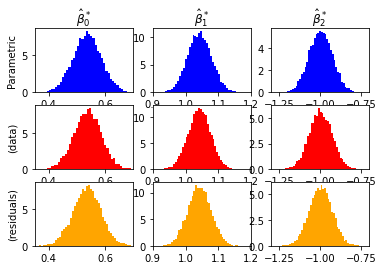

In [15]:

# Simulation settings
sigma = 0.5
beta_0 = 0.5
beta_1 = 1
beta_2 = -1
p = 0.5
n = 200

# Generate samples
np.random.seed(6011)

X1 = np.random.normal(loc = 0, scale = 1, size = n)
X2 = ss.bernoulli.rvs(p = p, size = n)
eps = np.random.normal(loc = 0, scale = sigma, size = n)

X = np.zeros((n,3))
X[:, 0] = 1
X[:, 1] = X1
X[:, 2] = X2

Y = beta_0 + beta_1 * X1 + beta_2 * X2 + eps

def linear_reg(X,Y): # Solve the MLE beta and sigma^2 for linear regression problem Y=Xbeta + eps
    n,p = X.shape
    beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), Y)
    eps_hat = Y - np.dot(X, beta_hat)
    sigmasq_hat = np.sum(eps_hat ** 2) / (n - p)
    return beta_hat, sigmasq_hat

beta_hat, sigmasq_hat = linear_reg(X,Y)

inv_XTX = np.linalg.inv(np.dot(X.transpose(), X))
se_beta_hat = np.sqrt(np.diag(inv_XTX) * sigmasq_hat)

# Bootstrap Regression
B = 10000
## Parametric
beta_hat_star_para = []
sigmasq_hat_star_para = []

for _ in range(B):
    new_eps = np.random.normal(loc = 0, scale= np.sqrt(sigmasq_hat), size = n)
    new_y = np.dot(X, beta_hat) + new_eps
    new_beta_hat, new_sigmasq_hat = linear_reg(X, new_y)
    beta_hat_star_para.append(new_beta_hat)
    sigmasq_hat_star_para.append(new_sigmasq_hat)

beta_hat_star_para = np.array(beta_hat_star_para)
sigmasq_hat_star_para = np.array(beta_hat_star_para)

std_beta_hat_para = np.std(beta_hat_star_para, axis = 0)
std_sigmasq_hat_para = np.std(sigmasq_hat_star_para)

## Nonparametric (data)
beta_hat_star_nonpara_1 = []
sigmasq_hat_star_nonpara_1 = []

for _ in range(B):
    new_ind = np.random.choice(range(n), size = n, replace=True)
    new_y = Y[new_ind]
    new_X = X[new_ind, :]
    new_beta_hat, new_sigmasq_hat = linear_reg(new_X, new_y)
    beta_hat_star_nonpara_1.append(new_beta_hat)
    sigmasq_hat_star_nonpara_1.append(new_sigmasq_hat)

beta_hat_star_nonpara_1 = np.array(beta_hat_star_nonpara_1)
sigmasq_hat_star_nonpara_1= np.array(beta_hat_star_nonpara_1)

std_beta_hat_nonpara_1 = np.std(beta_hat_star_nonpara_1, axis = 0)
std_sigmasq_hat_nonpara_1 = np.std(sigmasq_hat_star_nonpara_1)

## Nonparametric (residuals)
beta_hat_star_nonpara_2 = []
sigmasq_hat_star_nonpara_2 = []
eps_hat = Y - np.dot(X, beta_hat)

for _ in range(B):
    new_eps = np.random.choice(eps_hat, size = n, replace = True)
    new_y = np.dot(X, beta_hat) + new_eps
    new_beta_hat, new_sigmasq_hat = linear_reg(X, new_y)
    beta_hat_star_nonpara_2.append(new_beta_hat)
    sigmasq_hat_star_nonpara_2.append(new_sigmasq_hat)

beta_hat_star_nonpara_2 = np.array(beta_hat_star_nonpara_2)
sigmasq_hat_star_nonpara_2= np.array(beta_hat_star_nonpara_2)

std_beta_hat_nonpara_2 = np.std(beta_hat_star_nonpara_2, axis = 0)
std_sigmasq_hat_nonpara_2 = np.std(sigmasq_hat_star_nonpara_2)


##
print(se_beta_hat)
print(std_beta_hat_para)
print(std_beta_hat_nonpara_1)
print(std_beta_hat_nonpara_2)

print(std_sigmasq_hat_para)
print(std_sigmasq_hat_nonpara_1)
print(std_sigmasq_hat_nonpara_2)


fig, ax = plt.subplots(3, 3)

ax[0,0].set_title(r"$\hat{\beta}^*_0$")
ax[0,0].hist(beta_hat_star_para[:,0], bins=50, density=True, color = 'blue')
ax[0,0].set_ylabel("Parametric")
ax[0,0].set_xlim(0.35, 0.70)

ax[1,0].hist(beta_hat_star_nonpara_1[:,0], bins=50, density=True, color = 'red')
ax[1,0].set_ylabel("(data)")
ax[1,0].set_xlim(0.35, 0.70)

ax[2,0].hist(beta_hat_star_nonpara_2[:,0], bins=50, density=True, color = 'orange')
ax[2,0].set_ylabel("(residuals)")
ax[2,0].set_xlim(0.35, 0.70)

ax[0,1].set_title(r"$\hat{\beta}^*_1$")

ax[0,1].hist(beta_hat_star_para[:,1], bins=50, density=True, color = 'blue')
ax[1,1].hist(beta_hat_star_nonpara_1[:,1], bins=50, density=True, color = 'red')
ax[2,1].hist(beta_hat_star_nonpara_2[:,1], bins=50, density=True, color = 'orange')

ax[0,1].set_xlim(0.9, 1.2)
ax[1,1].set_xlim(0.9, 1.2)
ax[2,1].set_xlim(0.9, 1.2)


ax[0,2].set_title(r"$\hat{\beta}^*_2$")
ax[0,2].hist(beta_hat_star_para[:,2], bins=50, density=True, color = 'blue')
ax[1,2].hist(beta_hat_star_nonpara_1[:,2], bins=50, density=True, color = 'red')
ax[2,2].hist(beta_hat_star_nonpara_2[:,2], bins=50, density=True, color = 'orange')

ax[0,2].set_xlim(-1.3, -0.7)
ax[1,2].set_xlim(-1.3, -0.7)
ax[2,2].set_xlim(-1.3, -0.7)
plt.show()

## Two-sample mean Test
Given two independent samples $x_1, \dots, x_m \sim F_X$ and $y_1,\dots, y_n \sim F_Y$, denote $\mu_X$ and $\mu_Y$ as the expected value of $X$ and $Y$, respectively.
$$H_0: \mu_X = \mu_Y\quad {\rm versus}\quad H_1:\mu_X \neq \mu_Y$$ 
Here we simulate $m=n=40;~ x_i \sim N(0.5,1),i=1,\dots,m;~ y_j \sim N(0,1), j=1,\dots,n$.
	
Hypothesis testing procedure:
$$T = \frac{\bar{x} - \bar{y}}{\sqrt{\hat{\sigma}^2_X / m + \hat{\sigma}^2_Y / n}}$$
$$p_0 = 2\min(\Phi(T),1-\Phi(T)) \quad ({\rm Z-test})$$
By simulating corresponding $\boldsymbol{x}$ and $\boldsymbol{y}$, we have
	$$T = 1.69355,~p-{\rm value}_{\rm Z} = 0.09035,~p-{\rm value}_{t} = 0.094355.$$

1. Calculate the Wald-t statistic $T$.
2. For $i=1,\dots,B$, resample the data under the null to derive $T^{*(1)},\dots, T^{*(B)}$. We have two resampling approaches to satisfy the null hypothesis:

   (1). Denote $\boldsymbol{z} = (x_1,\dots, x_m, y_1,\dots, y_n)$, draw the $\boldsymbol{z}^{*(i)}$ from $\boldsymbol{z}$ and let     $\boldsymbol{x}^{*(i)} = \boldsymbol{z}^{*(i)}[1:m],~\boldsymbol{y}^{*(i)} = \boldsymbol{z}^{*(i)}[(m+1):(m+n)]$,
   
   (2). Let $\tilde{y}_j = y_j + \bar{x} - \bar{y}$. Draw $\boldsymbol{x}^{*(i)}$ from $(x_1,\dots,x_m)$ and $\boldsymbol{y}^{*(i)}$ from $(\tilde{y}_1,\dots,\tilde{y}_n)$ with replacement.
3. Obtain the proportion of resampling test statistics which are more ``extreme'' than $T$. 

1.6935495208839337 0.09035091717483112
Ttest_indResult(statistic=1.6935495208839337, pvalue=0.09435532544253074)
0.09473
0.09235
xbar - ybar: 0.43189960334757616
95% confidence interval of the difference of two means:[-0.06157487713800602,0.9253740838331583]
0.08627134228466171


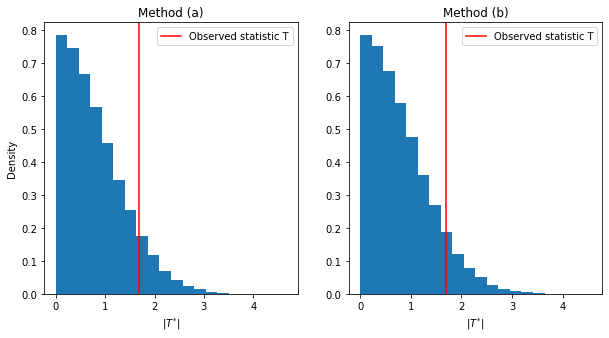

C:\Users\mengxuran\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\mengxuran\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

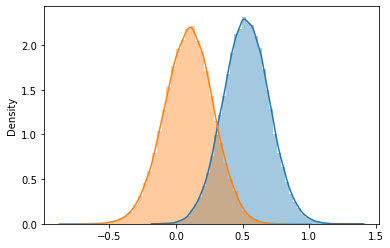

In [4]:
# Bootstrap two-sample mean test
# Simulation settings
np.random.seed(8)
m = 40
n = 40
mu_X = 0.5
mu_Y = 0
sigma_X = 1
sigma_Y = 1


# Simulate data
x = scipy.stats.norm.rvs(loc = mu_X, scale = sigma_X, size = m)
y = scipy.stats.norm.rvs(loc = mu_Y, scale = sigma_Y, size = n)


# Two-sample mean test
def cal_T(x,y): # Calculate the Z-statistic
    xhat = np.mean(x)
    yhat = np.mean(y)
    # print(xhat, yhat)
    sigma_xhat = np.std(x, ddof = 1)
    sigma_yhat = np.std(y, ddof = 1)
    T = (xhat - yhat) / np.sqrt(sigma_xhat ** 2 / m + sigma_yhat ** 2 /n)
    return T

# Frequentist test
T = cal_T(x,y)
pval_norm = 2 * min(scipy.stats.norm.cdf(T), 1 - scipy.stats.norm.cdf(T))
print(T, pval_norm)

# T test
pval_t = scipy.stats.ttest_ind(x,y, equal_var= False)
print(pval_t)

B = 100000
# Resample under null

##1 mixture of x and y
mix_xy = np.hstack((x,y))

Tstar1 = []
for _ in range(B):
    mix_star = np.random.choice(mix_xy, size = m+n, replace = False)
    xstar = mix_star[:m]
    ystar = mix_star[m:]
    Tstar1.append(cal_T(xstar, ystar))

pval_resample1 = np.mean(np.abs(Tstar1) >= T)
print(pval_resample1)

##2 reconstruct samples
y_re = y + np.mean(x) - np.mean(y)

Tstar2 = []
for _ in range(B):
    xstar = np.random.choice(x, size = m, replace = True)
    ystar = np.random.choice(y_re, size=n, replace=True)
    Tstar2.append(cal_T(xstar, ystar))

pval_resample2 = np.mean(np.abs(Tstar2) >= T)
print(pval_resample2)


# Resample from the original
# calculate the variance of xhat and yhat

xhat_star = []
yhat_star = []

for _ in range(B):
    xstar = np.random.choice(x, size=m, replace=True)
    ystar = np.random.choice(y, size=n, replace=True)
    xhat_star.append(np.mean(xstar))
    yhat_star.append(np.mean(ystar))

exact_meandiff = np.mean(x) - np.mean(y)
var_xhat = np.var(xhat_star)
var_yhat = np.var(yhat_star)
std_meandiff = np.sqrt(var_xhat + var_yhat)
print("xbar - ybar:",exact_meandiff)
alpha = 0.05
z_halfalpha = scipy.stats.norm.ppf(1 - alpha / 2)
lb_meandiff = exact_meandiff - std_meandiff * z_halfalpha
ub_meandiff = exact_meandiff + std_meandiff * z_halfalpha

print("95% confidence interval of the difference of two means:[{},{}]".format(lb_meandiff, ub_meandiff))
wald_meandiff = exact_meandiff / std_meandiff
pval_wald_norm = 2 * min(scipy.stats.norm.cdf(wald_meandiff), 1-scipy.stats.norm.cdf(wald_meandiff))
print(pval_wald_norm)


# plots
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(121)
ax1.hist(abs(np.array(Tstar1)), bins = 20, density = True)
ax1.set_xlabel("$|T^{*}|$")
ax1.set_ylabel("Density")
ax1.axvline(T, color = 'red', label = 'Observed statistic T')
ax1.set_title("Method (a)")
ax1.legend()

ax2 = fig1.add_subplot(122)
ax2.hist(abs(np.array(Tstar2)), bins = 20, density = True)
ax2.set_xlabel("$|T^{*}|$")
ax2.axvline(T, color = 'red', label = 'Observed statistic T')
ax2.set_title("Method (b)")
ax2.legend()
plt.show()


import seaborn as sns
fig2 = plt.figure()
sns.distplot(xhat_star)

sns.distplot(yhat_star)

# DP Process
## Definition
Given a measurable set $\Theta$, a base probability distribution $H$ and a positive real number $\alpha$, we say $G$ is Dirichlet process distributed with base distribution $H$ and concentration parameter $\alpha$, written $G\sim DP(\alpha, H)$, if for any finite measurable partition $\{B_1,\dots, B_k\}$ of $\Theta$, 
\begin{align*}
(G(B_1), \dots, G(B_k)) \sim \text{Dir}(\alpha H(B_1), \dots, \alpha H(B_k)).
\end{align*}

## Properties
1. For $A \in \Theta$, $G(A) \sim \text{Beta}(\alpha H(A), \alpha (1 - H(A)))$
2. $E(G(A)) = H(A), Var(G(A)) = \frac{H(A) (1 - H(A))}{\alpha +1}$
3. $\alpha \rightarrow \infty,~ G \rightarrow H$
4. Conjugacy: 
\begin{align*}
P&\sim DP(\alpha, H), \\
X_1, \dots, X_n &\stackrel{i.i.d}{\sim} P,\\
P|X_1,\dots, X_n &\sim DP\left(\alpha + n, \frac{\alpha H + \sum_{i=1}^n \delta_{X_i}}{\alpha + n}\right),
\end{align*}
where $\delta_{X_i}(A)=\mathbf{1}(X_i \in A)$. 

## Proof
For any finite measurable partition $\{B_1,\dots, B_k\}$ of $\Theta$,
\begin{align*}
(P(B_1), \dots, P(B_k)) \sim \text{Dir}(\alpha H(B_1), \dots, \alpha H(B_k)).
\end{align*}
For observations $X_1, \dots, X_n$, let $n_j = \#\{i:X_i \in B_j\}, j=1,\dots, k,$
\begin{align*}
(P(B_1), \dots, P(B_k))|X_1,\dots, X_n &\propto \pi(P(B_1), \dots, P(B_k)) f(X_1,\dots, X_n | P(B_1), \dots, P(B_k))\\&\propto \prod_{j=1}^k P(B_j)^{\alpha H(B_j) - 1} \prod_{j=1}^k P(B_j)^{n_j}\\
&\sim \text{Dir}(\alpha H(B_1) + n_1, \dots, \alpha H(B_k)+n_k)\\
&\sim \text{Dir}(\alpha H(B_1) + \sum_{i=1}^n \delta_{X_i}(B_1), \dots, \alpha H(B_k)+\sum_{i=1}^n \delta_{X_i}(B_k))
\end{align*}
$\therefore~P|X_1,\dots, X_n \sim DP\left(\alpha + n, \frac{\alpha H + \sum_{i=1}^n \delta_{X_i}}{\alpha + n}\right)$

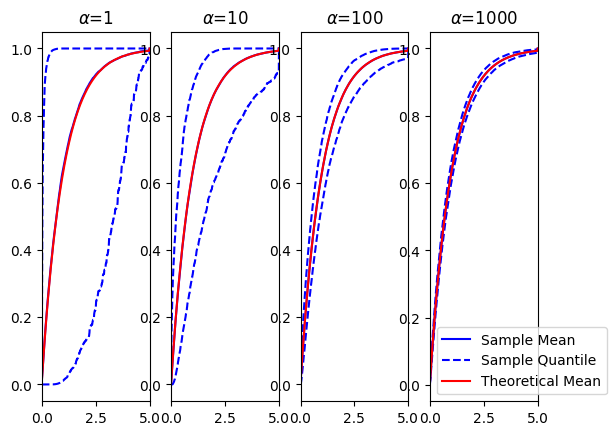

In [15]:
# Parameter settings
np.random.seed(6011)

alpha_list = [1, 10, 100, 1000]
alpha_conf = 0.05
# Partition of (0, inf)
ngrid = 1000
size = 5000

time_grids = np.concatenate((np.linspace(0, 5, ngrid), np.array([np.inf])), axis = 0)
fig, ax = plt.subplots(1, len(alpha_list))

t = 1

for ialpha in range(len(alpha_list)):
    alpha = alpha_list[ialpha]
    dir_prob = np.zeros(ngrid)
    # Exp_pdf = lambda * exp(-lambda * x), lambda = 1 / scale (in python `scipy.stats.expon' setting)

    for i in range(ngrid):
        # K=1000 
        # Generate H, H is a exponential distribution
        dir_prob[i] = scipy.stats.expon.cdf(time_grids[i+1], scale = 1) - scipy.stats.expon.cdf(time_grids[i], scale = 1)



    F_dir_samples = scipy.stats.dirichlet.rvs(alpha * dir_prob, size  = size)

    F_samples = np.cumsum(F_dir_samples, axis = 1) # horizontal cumsum 

    F_samples_mean = np.mean(F_samples,  axis = 0)
    F_samples_quan = np.quantile(F_samples, q = np.array([alpha_conf / 2, 1 - alpha_conf/ 2]), axis = 0)
    
    # theoretical mean
    base_cdf_mean = scipy.stats.expon.cdf(time_grids[1:], scale = 1)


    ax[ialpha].set_xlim((0,5))
    ax[ialpha].set_title( ("$\\alpha$=%d" % alpha) )
    ax[ialpha].plot(time_grids[:(len(time_grids)-1)], F_samples_mean, color = 'blue', label = 'Sample Mean')
    ax[ialpha].plot(time_grids[:(len(time_grids)-1)], F_samples_quan[0, :], color = 'blue', label = 'Sample Quantile', linestyle='dashed')
    ax[ialpha].plot(time_grids[:(len(time_grids)-1)], F_samples_quan[1, :], color = 'blue', linestyle='dashed')
    ax[ialpha].plot(time_grids[:(len(time_grids)-1)], base_cdf_mean, color = 'red', label = 'Theoretical Mean')

ax[ialpha].legend()
plt.show()


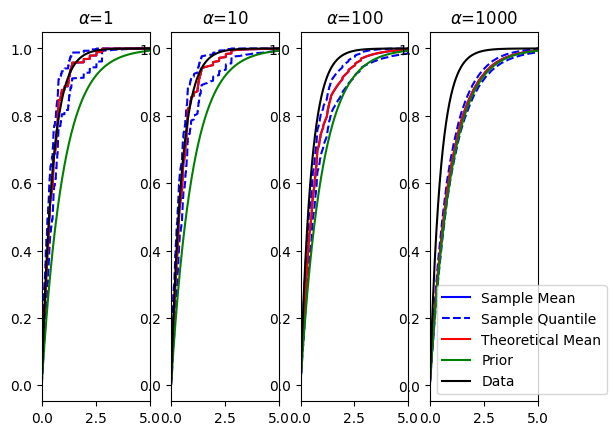

In [17]:
# Posterior
nX = 100
rateX = 2
X = scipy.stats.expon.rvs(size = nX, scale = 1.0 / rateX)

fig3, ax3 = plt.subplots(1, len(alpha_list))

for ialpha in range(len(alpha_list)):
    alpha = alpha_list[ialpha]
    dir_prob = np.zeros(ngrid)
    # Exp_pdf = lambda * exp(-lambda * x), lambda = 1 / scale (in python `scipy.stats.expon' setting)

    base_cdf_mean = alpha * scipy.stats.expon.cdf(time_grids[1:], scale = 1)

    for i in range(ngrid):
        dir_prob[i] = alpha * (scipy.stats.expon.cdf(time_grids[i+1], scale = 1) - scipy.stats.expon.cdf(time_grids[i], scale = 1))
        dir_prob[i] += np.sum((X > time_grids[i]) & (X <= time_grids[i+1]))
        base_cdf_mean[i] += np.sum((X <= time_grids[i+1]))
    base_cdf_mean /= (alpha + nX)

    F_dir_samples = scipy.stats.dirichlet.rvs(dir_prob, size  = size)

    F_samples = np.cumsum(F_dir_samples, axis = 1)

    F_samples_mean = np.mean(F_samples,  axis = 0)
    F_samples_quan = np.quantile(F_samples, q = np.array([alpha_conf / 2, 1 - alpha_conf/ 2]), axis = 0)


    prior_cdf = scipy.stats.expon.cdf(time_grids[1:], scale = 1)
    data_cdf = scipy.stats.expon.cdf(time_grids[1:], scale = 1.0 / rateX)

    ax3[ialpha].set_xlim((0,5))
    ax3[ialpha].set_title( ("$\\alpha$=%d" % alpha) )
    ax3[ialpha].plot(time_grids[:(len(time_grids)-1)], F_samples_mean, color = 'blue', label = 'Sample Mean')
    ax3[ialpha].plot(time_grids[:(len(time_grids)-1)], F_samples_quan[0, :], color = 'blue', label = 'Sample Quantile', linestyle='dashed')
    ax3[ialpha].plot(time_grids[:(len(time_grids)-1)], F_samples_quan[1, :], color = 'blue', linestyle='dashed')
    ax3[ialpha].plot(time_grids[:(len(time_grids)-1)], base_cdf_mean, color = 'red', label = 'Theoretical Mean')
    ax3[ialpha].plot(time_grids[:(len(time_grids)-1)], prior_cdf, color = 'green', label = 'Prior')
    ax3[ialpha].plot(time_grids[:(len(time_grids)-1)], data_cdf, color = 'black', label = 'Data')
ax3[ialpha].legend()
plt.show()

